# What languages are used in the dataset?


In [1]:
import polars as pl
import numpy as np
from statsmodels.stats.proportion import proportion_confint

from pathlib import Path

import matplotlib.pyplot as plt
import matplotlib.transforms as transforms

from telegram_quality_control.visualization import single_col_figure, double_col_figure

from cmcrameri import cm

figure_style = "print"

plt.style.use('./resources/mpl_styles/default.mplstyle')

In [2]:
chat_lang = pl.read_parquet(Path("data/language_downloaded_chats.parquet"))

# filter for finished chats
chat_lang = chat_lang.filter((pl.col("status") == "finished") & (pl.col("lang") != "no_str"))

chat_lang

chat_id,lang,score,status,columns_used,__index_level_0__
i64,str,f64,str,str,i64
1,"""en""",0.875085,"""finished""","""messages""",0
2,"""ru""",0.987296,"""finished""","""messages""",1
3,"""en""",0.880803,"""finished""","""messages""",2
4,"""ru""",0.995698,"""finished""","""messages""",3
5,"""ru""",0.996825,"""finished""","""messages""",4
…,…,…,…,…,…
11308592,"""en""",0.764941,"""finished""","""messages""",1971
11308638,"""es""",0.988137,"""finished""","""messages""",1972
11309176,"""es""",0.965091,"""finished""","""messages""",1974


In [3]:
def count_languages(chat_lang, score_threshold=0.8, size_cutoff=None, max_languages=None):
    lang_stats = chat_lang.filter(pl.col("score") > score_threshold)["lang"].value_counts()
    lang_stats = lang_stats.sort("count", descending=True)

    if size_cutoff is not None:
        small_languages = lang_stats["count"] < size_cutoff * sum(lang_stats["count"])

    elif max_languages is not None:
        cutoff = lang_stats[max_languages - 1]["count"]
        small_languages = lang_stats["count"] < cutoff

    else:
        raise ValueError("Either size_cutoff or max_languages has to be set!")

    lang_stats_small = lang_stats.filter(small_languages)
    lang_stats = lang_stats.filter(~small_languages)
    lang_stats = lang_stats.extend(
        pl.DataFrame(
            {"lang": "other", "count": lang_stats_small["count"].sum()}, schema=lang_stats.schema
        )
    )

    # calculate confidence intervals
    total = lang_stats["count"].sum()

    lower, upper = proportion_confint(lang_stats["count"], total, method='wilson')

    lang_stats = lang_stats.with_columns(
        error_lower=lang_stats["count"] - lower * total,
        error_upper=upper * total - lang_stats["count"],
        lower_p=lower,
        upper_p=upper,
    )

    return lang_stats

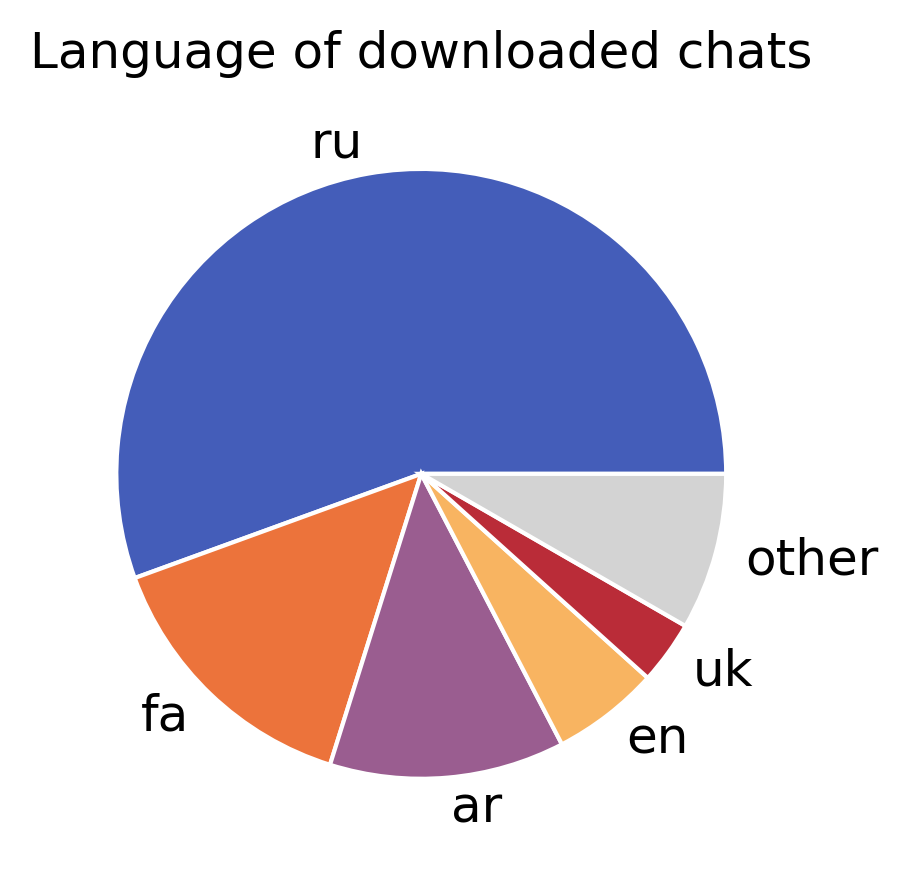

In [4]:
lang_stats = count_languages(chat_lang, size_cutoff=0.02)


def autopct(x):
    if x > 10:
        return "%1.1f%%" % x
    else:
        return ""


prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

colors = colors[: len(lang_stats) - 1] + ["lightgray"]

fig = single_col_figure(1)
ax = fig.add_subplot(111)
_ = ax.pie(
    lang_stats["count"],
    labels=lang_stats["lang"],
    colors=colors,
    textprops={'fontsize': 12},
    wedgeprops={'edgecolor': 'white'},
)
plt.title("Language of downloaded chats")

plt.savefig(f"./figures/language_dist.pdf", bbox_inches='tight')

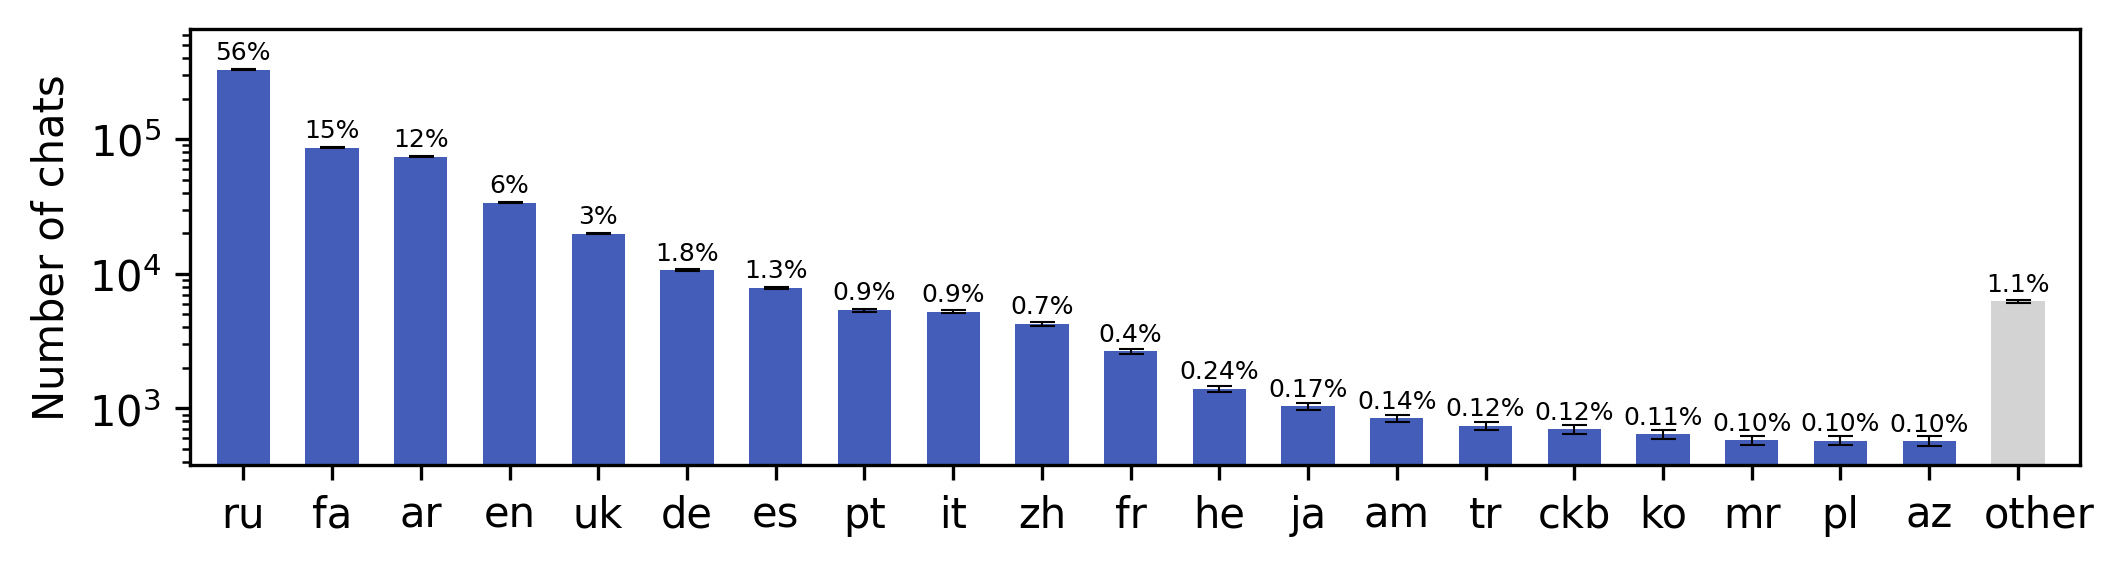

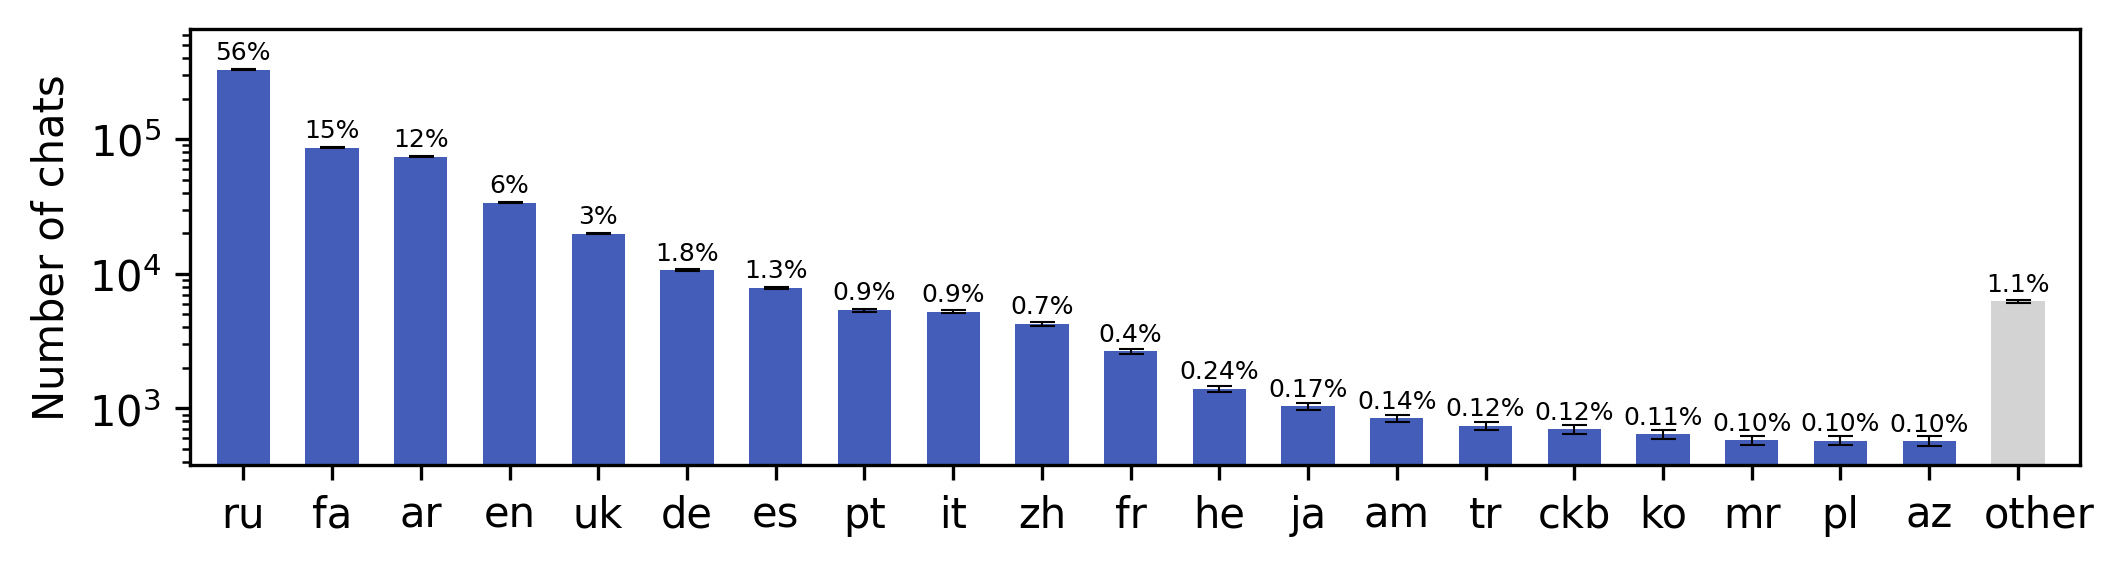

In [5]:
lang_stats = count_languages(chat_lang, max_languages=20)

fig = double_col_figure(0.25)
ax = fig.add_subplot(111)

colors = ['C0'] * (len(lang_stats) - 1) + ['lightgray']

bars = ax.bar(
    lang_stats["lang"],
    lang_stats["count"],
    yerr=[lang_stats["error_lower"], lang_stats["error_upper"]],
    color=colors,
    capsize=3,
    ecolor="black",
    width=0.6,
    error_kw={
        "linewidth": 0.5,
        "capthick": 0.5,
    },
)

total = lang_stats["count"].sum()
for bar, count in zip(bars, lang_stats["count"]):
    # height = bar.get_height()
    height = bar.get_height() * 1.1
    percentage = 100 * count / total
    if percentage < 0.3:
        text = f'{percentage:.2f}%'
    elif percentage < 3:
        text = f'{percentage:.1f}%'
    elif percentage < 30:
        text = f'{percentage:.0f}%'
    else:
        text = f'{percentage:.0f}%'
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        text,
        ha='center',
        va='bottom',
        fontsize=6,
    )

ax.set_yscale('log')
ax.set_ylabel("Number of chats")
ax.set_ylim(top=bars[0].get_height() * 2)
ax.set_xlim(-0.6, len(lang_stats) - 0.3)

# shift the last label a bit to the right
labels = ax.get_xticklabels()
dx = 5 / 72.0
dy = 0 / 72.0
offset = transforms.ScaledTranslation(dx, dy, fig.dpi_scale_trans)
labels[-1].set_transform(labels[-1].get_transform() + offset)

fig.tight_layout()
plt.subplots_adjust(left=0.08, bottom=0.14, top=0.97, right=0.98)

fig.savefig("figures/language_bars.pdf")
fig.savefig("figures/language_bars.png")
fig

In [6]:
lang_stats

lang,count,error_lower,error_upper,lower_p,upper_p
str,u32,f64,f64,f64,f64
"""ru""",329884,750.722576,750.296065,0.55425,0.556778
"""fa""",86769,532.134829,534.85367,0.14522,0.147017
"""ar""",74059,497.572252,500.455532,0.123875,0.125556
"""en""",33829,348.372107,351.775871,0.05638,0.057559
"""uk""",19926,270.199346,273.782983,0.0331,0.034016
…,…,…,…,…,…
"""ko""",641,47.715823,51.548964,0.000999,0.001166
"""mr""",579,45.260316,49.094259,0.000899,0.001058
"""pl""",576,45.138238,48.97222,0.000894,0.001052


In [7]:
np.cumsum(lang_stats["count"]) / total

array([0.55551458, 0.70163092, 0.82634402, 0.88331102, 0.9168658 ,
       0.93480175, 0.94802428, 0.95707562, 0.96590635, 0.97304975,
       0.97751901, 0.97987993, 0.98162789, 0.98304411, 0.98429193,
       0.98546566, 0.98654508, 0.9875201 , 0.98849007, 0.98944993,
       1.        ])